In [1]:
import numpy as np
from __future__ import print_function
from sklearn import metrics

In [40]:
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

In [ ]:
labels = ['B-celltypeline',
 'B-cellularcomponent',
 'B-mirna',
 'B-organismsspecies',
 'B-proteingene',
 'B-smallmolecule',
 'B-tissuesorgans',
 'I-celltypeline',
 'I-cellularcomponent',
 'I-organismsspecies',
 'I-proteingene',
 'I-smallmolecule',
 'I-tissuesorgans',
 'O']

In [4]:
def read_file(filename):
    f = open(filename)

    lines = f.readlines()

    sentences = []
    sentence = []
    for l in lines:
        if l == '\n':
            sentences.append(sentence)
            sentence = []
            continue

        sentence.append(l[:-1].split(' '))
        # TODO: utf-8?


    label_stats = {}
    for s in sentences:
        for w in s:
            label = w[1] == 'O'
            if label not in label_stats:
                label_stats[label] = 0
            label_stats[label] += 1

    X = []
    Y = []
    for s in sentences:
        x = []
        y = []
        for word, label in s:
            x += [ord(w) for w in word]
            y += [1 if label=='O' else 2] * len(word)

            x.append(ord(' '))
            y.append(1)

        X.append(x)
        Y.append(y)

    return X,Y,label_stats

In [5]:
trainX, trainY, train_labels = read_file('data_v2/train.iob2')
devX, devY, dev_labels = read_file('data_v2/dev.iob2')
testX, testY, test_labels = read_file('data_v2/test.iob2')

In [6]:
train_labels, dev_labels, test_labels

({False: 70267, True: 502341},
 {False: 8216, True: 59002},
 {False: 8295, True: 60997})

In [7]:
def print_label(l):
    if l == 1:
        print("·", end='')
    else:
        print("%X" % l, end='')
    
def print_seq(x,y,y_true=None,start=0,end=None, line_length=80):
    if end is None:
        end = len(x)
    
    line_count = int(np.ceil(1.0*(end-start)/line_length))
    for line in range(line_count):
        st = start + line * line_length
        en = np.min([end, st + line_length])
        
        if y_true is not None:
            for i in range(st, en):
                print_label(y_true[i])
            print(" ")

        for i in range(st, en):
            print_label(y[i])

        print(" ")
        for i in range(st, en):
            print(chr(x[i]), end='')
        
        print("\n")

In [8]:
print_seq(testX[0], testY[0], None, 0, 100)

····222222·22222·······················222222222································ 
(A) HEK293 cells were transfected with DAPK��CaM or with a control vector (pcDNA

···················· 
3-luciferase, LUC), 



# Neural model

In [9]:
import theano

Using cuDNN version 6021 on context None
Mapped name None to device cuda0: GeForce GTX 980 (0000:01:00.0)


In [10]:
theano.config.device

'cuda0'

In [11]:
theano.config.optimizer='fast_run'

In [12]:
import keras
from keras import backend as K
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution1D, Convolution2D, Embedding, Reshape, BatchNormalization

Using Theano backend.


In [13]:
max_len = 150

In [16]:
def prepare_for_keras(X, Y, max_len):
    X_ = sequence.pad_sequences(X, maxlen=max_len, padding='post', truncating='post')
    
    Y_ = sequence.pad_sequences(Y, maxlen=max_len, padding='post', truncating='post')

    Y_one_hot = np.array([keras.utils.to_categorical(y, num_classes=3) for y in Y_])
    
    # Convert labels to categorical one-hot encoding
    return X_, Y_one_hot

In [17]:
trainX_, trainY_ = prepare_for_keras(trainX, trainY, max_len)

In [18]:
devX_, devY_ = prepare_for_keras(devX, devY, max_len)

In [19]:
testX_, testY_ = prepare_for_keras(testX, testY, max_len)

In [20]:
train_final_labels = np.argmax(trainY_,-1).reshape(-1)

In [21]:
class_weights = np.zeros(3, dtype=np.float)
for i in range(3):
    class_weights[i] = (train_final_labels==i).sum()

In [22]:
class_weights = class_weights.sum() / class_weights
class_weights[0] = 0

In [53]:
from keras.losses import categorical_crossentropy
def categorical_crossentropy_flatten(y_true, y_pred):
    tmp = categorical_crossentropy(y_true, y_pred)
    y_true_argmax = y_true.argmax(axis=-1)
    weights = K.constant(
#         class_weights
#         np.log(class_weights+1)
        np.sqrt(class_weights)
    )[y_true_argmax]
    
    return tmp * weights

In [54]:

model = Sequential()
model.add(Embedding(256, 16, mask_zero=False, input_length=max_len))
print(model.layers[-1].output_shape)

model.add(Reshape(target_shape=(-1,16,1)))
print(model.layers[-1].output_shape)

model.add(Convolution2D(16, 5, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
print(model.layers[-1].output_shape)

for i in range(4):
    model.add(Convolution2D(16, 5, strides=(1,2), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    print(model.layers[-1].output_shape)
    
    model.add(Convolution2D(16, 5, strides=(1,1), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    print(model.layers[-1].output_shape)

model.add(Convolution2D(3, 5, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
print(model.layers[-1].output_shape)

model.add(Reshape((-1, 3)))
print(model.layers[-1].output_shape)

model.add(Activation('softmax', name='last_softmax'))
print(model.layers[-1].output_shape)

#model.add(FlattenFirst())
#print(model.layers[-1].output_shape)

model.compile(optimizer=keras.optimizers.Adam(lr=0.01),
              loss=categorical_crossentropy_flatten,
              metrics=['accuracy'])

(None, 150, 16)
(None, 150, 16, 1)
(None, 150, 16, 16)
(None, 150, 8, 16)
(None, 150, 8, 16)
(None, 150, 4, 16)
(None, 150, 4, 16)
(None, 150, 2, 16)
(None, 150, 2, 16)
(None, 150, 1, 16)
(None, 150, 1, 16)
(None, 150, 1, 3)
(None, 150, 3)
(None, 150, 3)


In [56]:
history = model.fit(
    trainX_, 
    trainY_, 
    epochs=30, batch_size=128, validation_data=(devX_, devY_),
    callbacks = [
        keras.callbacks.ModelCheckpoint(
            'binary.sqrt.weights.{epoch:02d}-{val_loss:.2f}.hdf5', 
            monitor='val_loss', verbose=1, 
            save_best_only=True, save_weights_only=False, mode='auto', period=1)
    ]
)

Train on 34307 samples, validate on 4037 samples
Epoch 1/30
34307/34307 [==============================] - 318s - loss: 0.4653 - acc: 0.9145 - val_loss: 1.1613 - val_acc: 0.5334
Epoch 2/30
34307/34307 [==============================] - 321s - loss: 0.2057 - acc: 0.9474 - val_loss: 0.2446 - val_acc: 0.9583
Epoch 3/30
34307/34307 [==============================] - 321s - loss: 0.1644 - acc: 0.9518 - val_loss: 0.6765 - val_acc: 0.8038
Epoch 4/30
34307/34307 [==============================] - 321s - loss: 0.1802 - acc: 0.9446 - val_loss: 0.2135 - val_acc: 0.9470
Epoch 5/30
34307/34307 [==============================] - 321s - loss: 0.1364 - acc: 0.9554 - val_loss: 0.1867 - val_acc: 0.9609
Epoch 6/30
34307/34307 [==============================] - 321s - loss: 0.1289 - acc: 0.9352 - val_loss: 0.2125 - val_acc: 0.9356
Epoch 7/30
34307/34307 [==============================] - 321s - loss: 0.1196 - acc: 0.9433 - val_loss: 0.2173 - val_acc: 0.9457
Epoch 8/30
34307/34307 [========================

KeyboardInterrupt: 

In [ ]:
history = _

In [ ]:
history.history

In [35]:
train_pred = model.predict_classes(trainX_, batch_size=1024)

train_truth = np.argmax(trainY_, -1)
nonzero = train_truth != 0
t = (train_pred[nonzero] == train_truth[nonzero]).sum()
t1 = nonzero.sum()
print("char level accuracy:", 1.0*t/t1)

cm = metrics.confusion_matrix(train_truth.flatten(), train_pred.flatten())

34307/34307 [==============================] - 72s    
char level accuracy: 0.873798344392


In [37]:
from keras.models import load_model

In [57]:
loadedmodel = load_model('binary.sqrt.weights.04-0.19.hdf5', custom_objects=locals())

In [58]:
dev_pred = loadedmodel.predict_classes(devX_, batch_size=64)

dev_truth = np.argmax(devY_, -1)
nonzero = dev_truth != 0
t = (dev_pred[nonzero] == dev_truth[nonzero]).sum()
t1 = nonzero.sum() # dev_pred.shape[0]*dev_pred.shape[1]
print("char level accuracy:", 1.0*t/t1)

cm = metrics.confusion_matrix(dev_truth.flatten(), dev_pred.flatten())

4032/4037 [============================>.] - ETA: 0schar level accuracy: 0.940004199414


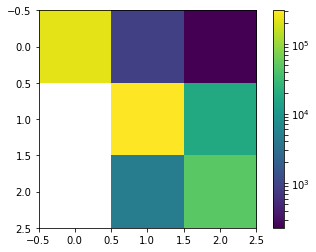

In [59]:
plt.imshow(cm, norm=LogNorm())
plt.colorbar();

In [60]:
for i in range(100):
    print_seq(devX_[i], devY_[i].argmax(axis=-1), dev_pred[i], end=150)
    print("\n")

······················2222222222·222222·······2····2··22222222222·22222········· 
······················2222222222·222222···············22222222222·22222········· 
(A) Sections from the cerebellar vermis of a 70-d-old npc1���/��� mouse were sta

··········22222222222222······················222·····2222············ 
··········22222222222222······················222····················2 
ined with anti-Calbindin (green) to visualize PCs and 7AAD (red) for n



·························································222···················· 
·························222··············222222·222·····222····222222·2········ 
Although there are scant PCs remaining in lobule II, the PCs in lobule X have no

·············000000000000000000000000000000000000000000000000000000000 
·············000000000000000000000000000000000000000000000000000000000 
t decreased.                                                          



··································222222222222222222222··········0000000

a.                                                                    



······················2222222222222·····················22222·000000000000000000 
······················2222222222222·····················22222·000000000000000000 
(B) Quantification of npc1���/���PC density in chimeric mice.                   

0000000000000000000000000000000000000000000000000000000000000000000000 
0000000000000000000000000000000000000000000000000000000000000000000000 
                                                                      



·········222222································································· 
·········222222································································· 
For each mouse, the actual density observed (the average of the mean densities c

······································································ 
································································22···· 
ounted in each lobule) is compared to the number expected if no PC los



The GFP transgene is apparently poorly expressed in microglia, as all microglia 

··················································00000000000000000000 
··················································00000000000000000000 
appear GFP-negative regardless of their genotype.                     



··········222·····················································22222·00000000 
··········222············································22222222·22222·00000000 
E) Mutant PCs are lost even when surrounded by wild-type Bergmann glia.         

0000000000000000000000000000000000000000000000000000000000000000000000 
0000000000000000000000000000000000000000000000000000000000000000000000 
                                                                      



····················22222····2222···················22222222222·2··············2 
·················22·································22222222222················2 
A stretch of the PC layer in C4.8 is shown where no npc1���/��� (GFP-pos

Increased Autophagy in npc1PCs EM of npc1���/��� and wild-type PCs from anterior

·222222····2222·22··22222·00000000000000000000000000000000000000000000 
·222222·············22222·00000000000000000000000000000000000000000000 
 vermis of 48-d-old mice.                                             



·································2222222··00000000000000000000000000000000000000 
·································2222222·000000000000000000000000000000000000000 
(A) Low-power field of a typical npc1PC.                                        

0000000000000000000000000000000000000000000000000000000000000000000000 
0000000000000000000000000000000000000000000000000000000000000000000000 
                                                                      



·····························2······························22222222222222·····2 
···············································································2 
(B) Magnification of the red box in (A) showing accumulated multivesicul

····················20000000000000000000000000000000000000000000000000 
····················00000000000000000000000000000000000000000000000000 
 starvation medium.                                                   



···············································222222222222····················· 
····························································22222·22222222······ 
Aliquots were taken at the indicated times and acid-soluble small peptides gener

·····································000000000000000000000000000000000 
·····································000000000000000000000000000000000 
ated by proteolysis were determined.                                  



················································································ 
················································································ 
(C) Cells were grown in control or in starvation medium and visualized by light 

·············000000000000000000000000000000000000000000000000000000000 


In [68]:
def print_word(word, label_votes, f):
    label = 'O' if label_votes.argmax()==0 else 'E'
    f.write("{} {}\n".format(''.join(word), label))

def print_iob2(X, Y, f):
    for xsentence, ysentence in zip(X,Y):
        word = []
        votes = np.zeros(2)
        for x,y in zip(xsentence, ysentence):
            if chr(x)==' ':
                print_word(word, votes, f)
                word = []
                votes = np.zeros(2)
                continue
            word.append(chr(x))
            votes[y-1] += 1
        f.write("\n")

# Save to file

In [70]:
coef = 4
devX_full, devY_full = prepare_for_keras(devX, devY, max_len * coef)

In [71]:
dev_pred_full = None
for i in range(coef):
    t = loadedmodel.predict_classes(
        devX_full[:,i*max_len:(i+1)*max_len], batch_size=64)
    if dev_pred_full is None:
        dev_pred_full = t
    else:
        dev_pred_full = np.concatenate([dev_pred_full, t], axis=1)

print(dev_pred_full.shape)

dev_truth_full = np.argmax(devY_full, -1)
nonzero = dev_truth_full != 0
t = (dev_pred_full[nonzero] == dev_truth_full[nonzero]).sum()
t1 = nonzero.sum() # dev_pred.shape[0]*dev_pred.shape[1]
print("char level accuracy:", 1.0*t/t1)

cm = metrics.confusion_matrix(dev_truth_full.flatten(), dev_pred_full.flatten())

4032/4037 [============================>.] - ETA: 0s(4037, 600)
char level accuracy: 0.939058891652


In [72]:
for i in range(10):
    print_seq(devX_full[i], devY_full[i].argmax(axis=-1), dev_pred_full[i])
    print("\n")

······················2222222222·222222·······2····2··22222222222·22222········· 
······················2222222222·222222···············22222222222·22222········· 
(A) Sections from the cerebellar vermis of a 70-d-old npc1���/��� mouse were sta

··········22222222222222······················222·····2222············222222·000 
··········22222222222222······················222····················2222222·000 
ined with anti-Calbindin (green) to visualize PCs and 7AAD (red) for nuclei.    

00000000000000000000000000000000000000000000000000000000000000000000000000000000 
00000000000000000000000000000000000000000000000000000000000000000000000000000000 
                                                                                

000000000000000000000000000000000000000000000000000000000000·0000000000000000000 
00000000000000000000000000000000000000000000000000000000000000000000000000000000 
                                                                                

0000000000000000

                                                                                

00000000000000000000000000000000000000000000000000000000000000000000000000000000 
00000000000000000000000000000000000000000000000000000000000000000000000000000000 
                                                                                

0000000000000000000000000000000000000000 
0000000000000000000000000000000000000000 
                                        



··············22222·2222·222222·············22222······························· 
··············22222·2222·················22····································· 
Note that the glial cell bodies near the PC layer and the radial processes exten

························22222···················2222222222222222····22·········· 
················································2222222222222222················ 
ding into the molecular layer are intact in the npc1���/���mouse despite the los

·····2222·000000000000000000000000000000000000000000

In [73]:
print_iob2(devX_full, dev_pred_full, open('binary_dev_pred.iob2', 'w'))